In [1]:
# -*- coding: utf-8 -*-
"""
Updated 20 January 2025

"""

from IPython import get_ipython
print(__doc__)

# Clear all the variables
get_ipython().run_line_magic('reset', '-sf')

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path  
import sys
import os
import matplotlib.pyplot as plt

# Import configuration file
import sys
sys.path.append(str(Path('../src')))
import config as cfg

from maad import sound, features

# Close all the figures (like in Matlab)
plt.close("all")



Updated 20 January 2025




In [ ]:
"""****************************************************************************
# -------------------          options              ---------------------------
****************************************************************************"""

PROCESS_DATA = True
SAVE = False
DISPLAY = False
VERBOSE = True
CONFIG = cfg.load_config('config_publication.yaml')

In [7]:
"""****************************************************************************
# -------------- SELECT A SOUND FROM ITS FULL FILENAME   ---------------------------
****************************************************************************"""

# ###### RISOUX
# in the list find the dictionary with the key 'name' and the value 'risoux'
DATASET = [d for d in CONFIG['datasets'] if d['name'] == 'risoux'][0]
path = Path(DATASET['path']) 
# f = path / 'S4A03536_20190621_224500.wav' #1
# f = path / 'S4A03536_20190619_131500.wav' #3
# f = path / 'S4A03536_20190630_193000.wav' #4
# f = path / 'S4A03536_20190616_083000.wav' #6
f = path / 'S4A03536_20190621_123000.wav' #8
# f = path / 'S4A03536_20190627_064500.wav' #10
# f = path / 'S4A03536_20190101_121500.wav' 
# f = path / 'S4A03536_20190719_230000.wav' 
# f = path / 'S4A03536_20190206_160000.wav' 

# ######## PERU
# DATASET = [d for d in CONFIG['datasets'] if d['name'] == 'peru'][0]
# path = Path(DATASET['path']) 
# f = path / 'PER_006_S08_20190116_100007Z_00.wav' 
# f = path / 'PER_006_S08_20190116_100007Z_15.wav' 
# f = path / 'PER_006_S08_20190116_100007Z_30.wav'
# f = path / 'PER_006_S08_20190116_100007Z_45.wav'

########## UK_Sussex_countryside
# DATASET = [d for d in CONFIG['datasets'] if d['name'] == 'uk_sussex_countryside'][0]
# path = Path(DATASET['path']) 
# f = path / 'BA-01_0_20150619_0545.wav'
# f = path / 'BA-01_0_20150620_0402.wav'


########## Ecuador
# DATASET = [d for d in CONFIG['datasets'] if d['name'] == 'ecuador'][0]
# path = Path(DATASET['path']) 
# f = path / 'FS-13_0_20150808_1900.wav'
# f = path / 'PO-02_0_20150818_1845.wav'
# f = path / 'PO-02_0_20150818_0645.wav'
# f = path / 'TE-02_0_20150713_0600.wav'

# retrieve filename
_, filename_with_ext = os.path.split(f)
file = os.path.splitext(filename_with_ext)[0]

display('Processing {}.wav ...'.format(file))



'Processing S4A03536_20190621_123000.wav ...'

spectrogram dimension Nx=513 Ny=5166
max value of the spectrogram 0.00066
*************************************************************
   Time resolution dt=0.01s | Frequency resolution df=43.07Hz 
*************************************************************
seed_level 16dB / low_level 6dB
===> Number of ROIs before cleaning : 191
===> Number of ROIs after cleaning : 90
===> nROI : 90#/min | aROI : 4.66%


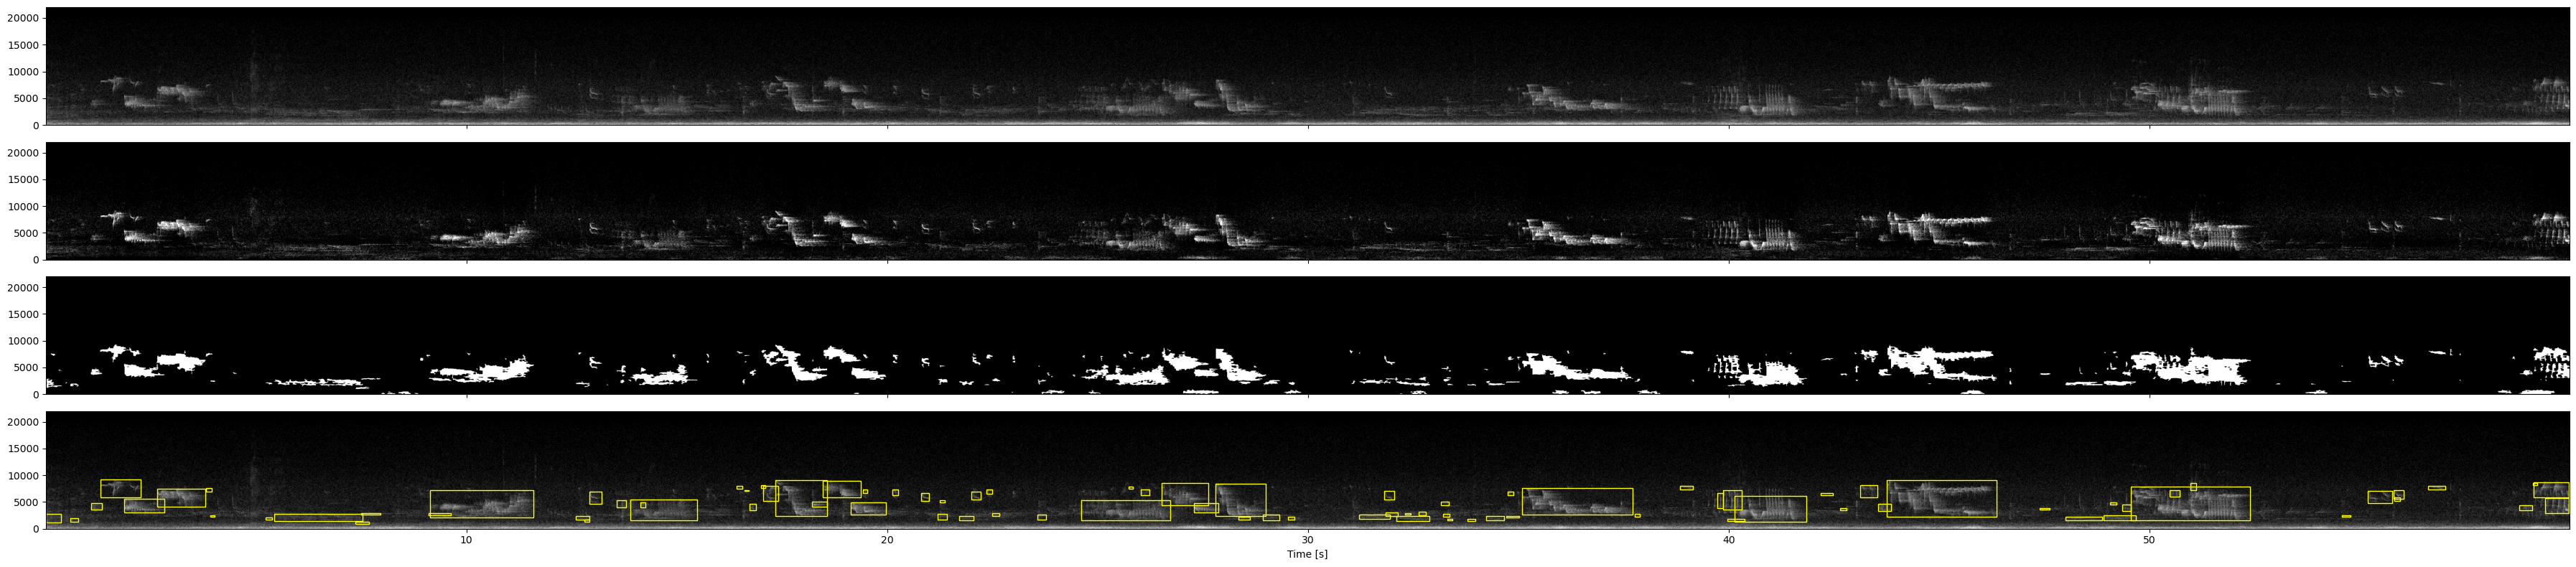

In [8]:
# Load the original sound (16bits) and get the sampling frequency fs
# try:
wave, fs = sound.load(
    filename=f,
    channel=CONFIG['channel'], 
    detrend=True, 
    verbose=False
    )

# resample to SAMPLING_FREQUENCY and update fs
wave = sound.resample(
    s=wave,
    fs=fs,
    target_fs=CONFIG['sampling_frequency'],
    )
fs = CONFIG['sampling_frequency']
duration = len(wave) / fs

# bandpass filter between BW_FREQ_MIN and BW_FREQ_MAX
if (DATASET['flim_min'] is not None) and (DATASET['flim_max'] is not None):   
    wave = sound.select_bandwidth(
        x=wave, 
        fs=fs, 
        fcut=(DATASET['flim_min'],DATASET['flim_max'] ), 
        forder = 5,
        ftype='bandpass')
elif DATASET['flim_max'] is not None:
    wave = sound.select_bandwidth(
        x=wave, 
        fs=fs, 
        fcut=(DATASET['flim_max']), 
        forder = 5,
        ftype='low')
elif DATASET['flim_min'] is not None :
    wave = sound.select_bandwidth(
        x=wave, 
        fs=fs, 
        fcut=(DATASET['flim_min']), 
        forder = 5,
        ftype='high')

# trim
if (DATASET['tlim_min'] is not None) and (DATASET['tlim_max'] is not None):
    wave = sound.trim(
        s=wave, 
        fs=fs,
        min_t=DATASET['tlim_min'],
        max_t=DATASET['tlim_max'] )
elif (DATASET['tlim_min'] is not None):
    wave = sound.trim(
        s=wave, 
        fs=fs,
        min_t=DATASET['tlim_min'],
        max_t=duration)
elif (DATASET['tlim_max'] is not None):
    wave = sound.trim(
        s=wave, 
        fs=fs,
        min_t=0,
        max_t=DATASET['tlim_max'] )

# Compute the Power Spectrogram Density (PSD) : Sxx_power
Sxx_power, tn, fn, ext = sound.spectrogram(
    wave,fs,
    window=CONFIG['window'],
    nperseg=CONFIG['n_fft'],
    noverlap=CONFIG['hop_length'],
    verbose=VERBOSE,
    display=False,
    savefig=None)

# compute nROI and aROI
nROI, aROI = features.region_of_interest_index(
    Sxx_power, tn, fn,   
    seed_level=CONFIG['seed_level'], 
    low_level=CONFIG['low_level'], 
    fusion_rois=CONFIG['fusion_rois'],
    remove_rois_flim_min = CONFIG['remove_rois_flim_min'],
    remove_rois_flim_max = CONFIG['remove_rois_flim_max'],
    remove_rain = CONFIG['remove_rain'],
    min_event_duration=CONFIG['min_event_duration'], 
    max_event_duration=CONFIG['max_event_duration'], 
    min_freq_bw=CONFIG['min_freq_bw'], 
    max_freq_bw=CONFIG['max_freq_bw'], 
    max_ratio_xy = CONFIG['max_ratio_xy'],
    display = True,
    verbose=True,
    **{'extent':ext})


